In [55]:
import os, io, re
import glob
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'family' : 'meiryo'}
plt.rc('font', **font)

In [56]:
from PIL import Image

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

In [57]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14655587334150049825,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4937233203
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9788313270770724739
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [58]:
score_list = []
l = ["羽場","長澤","常重","加藤"]

for i in l:
    score_list.append(pd.read_csv("PPP_CSV/score" + str(i) + ".csv", index_col=0,encoding="SJIS", dtype="int"))

In [59]:
def cos_sim(v1, v2):
    return round(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), 3)

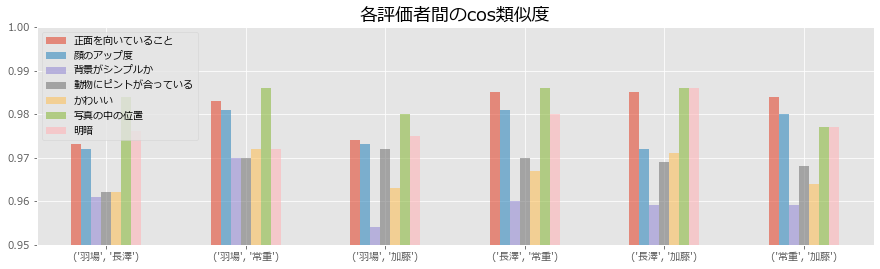

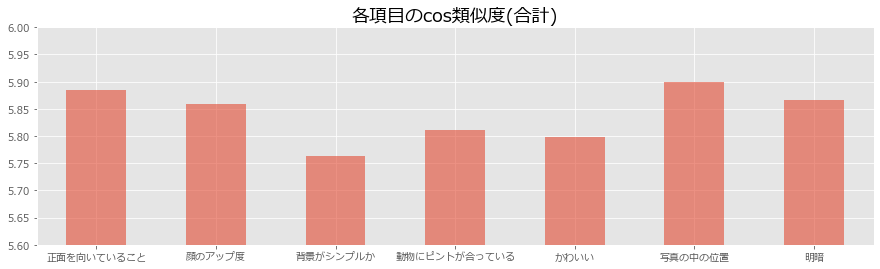

In [60]:
import itertools

result_df = pd.DataFrame(columns=score_list[0].columns)

for c in itertools.combinations(l, 2):
    result_df.loc[str(c)] = 0
    for column in score_list[0].columns:
        result_df[column][str(c)] = cos_sim(score_list[l.index(c[0])][column],score_list[l.index(c[1])][column])

result_df.plot.bar(y=result_df.columns, alpha=0.6, figsize=(15,4),ylim=[0.95, 1])
plt.xticks(rotation=0)
plt.title('各評価者間のcos類似度', size=18)
plt.show()

result_df.sum().plot.bar(alpha=0.6, figsize=(15,4),ylim=[5.6, 6])
plt.xticks(rotation=0)
plt.title('各項目のcos類似度(合計)', size=18)
plt.show()

In [61]:
#一様分布に従う乱数同士の類似度
temp_sim = 0

for i in range(10000):
    arr1 = np.random.randint(1, 6, (len(score_list[0].index)))
    arr2 = np.random.randint(1, 6, (len(score_list[0].index)))
    temp_sim += cos_sim(arr1, arr2)
print(temp_sim/10000)

0.8186498999999986


In [62]:
score_df = pd.read_csv("PPP_CSV/score.csv", index_col=0,encoding="SJIS", dtype="int")
score_df

,正面を向いていること,顔のアップ度,背景がシンプルか,動物にピントが合っている,かわいい,写真の中の位置,明暗
id,,,,,,,
37,16,12,20,16,12,12,8
85,20,16,9,16,13,14,12
86,20,16,14,18,15,13,13
308,12,9,9,10,12,13,9
355,12,11,9,17,9,11,6
...,...,...,...,...,...,...,...
4585,19,16,7,15,14,13,12
4592,20,18,9,18,17,13,12
4593,20,17,14,17,17,15,10


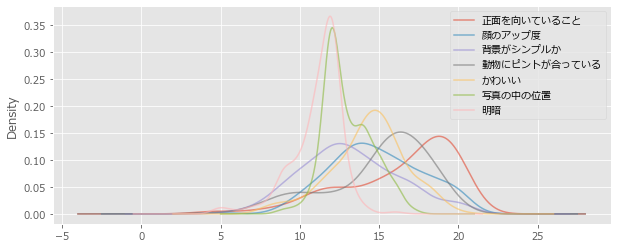

In [63]:
#分布確認
score_df.reset_index().drop("id",axis=1).plot.kde(alpha=0.6, figsize=(10,4))

In [64]:
def column_predict(X,Y):
    X = X.astype('float32') / 255
    X_train, X_valid, y_train, y_valid = train_test_split(X,Y,random_state = 0,test_size = 0.2)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(80,80,3)))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')

    model.fit(X_train, y_train, epochs=200, batch_size=20,verbose=0)

    pred = model.predict(X_valid)
    MSE_pred = mean_squared_error(pred, y_valid)
    print(MSE_pred)

    mean_pred = np.full(len(y_valid), y_train.mean())
    MSE_mean = mean_squared_error(mean_pred, y_valid)
    print(MSE_mean)

    plt.figure(figsize=(8, 4))

    plt.plot(y_valid, label="Actual")
    plt.plot(pred, c="b", label="pred", alpha=0.6)

    plt.legend(loc='upper right')
    plt.show()
    
    return(MSE_pred,MSE_mean)
    

In [81]:
image_size=80
X=[]
Y=[]

for index in score_df.index:
    #画像ファイル取得
    img_file = glob.glob("./csv_img/csv_img/img/" + str(index) + "/*")
    image = Image.open(img_file[0])
    
    image = image.convert('RGB')
    # リサイズ
    image = image.resize((image_size, image_size))

    X.append(np.asarray(image))
    
    #水増し
    row,col,ch= np.asarray(image).shape
    mean = 0
    sigma = 10
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    gauss_img = image + gauss
    
    X.append(np.asarray(gauss_img, dtype=np.uint8))
    
del image

AttributeError: 'numpy.ndarray' object has no attribute 'show'

正面を向いていること
36.84568420716823
11.799600187359898


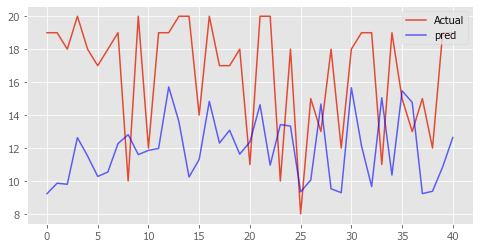

顔のアップ度
15.120913674367706
7.580991334604705


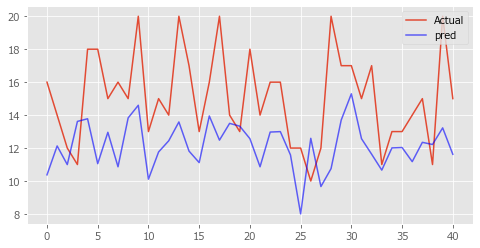

背景がシンプルか
11.862242602294517
10.588462496421945


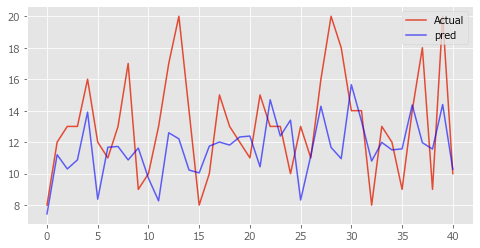

動物にピントが合っている
31.332440651841956
11.931052300920815


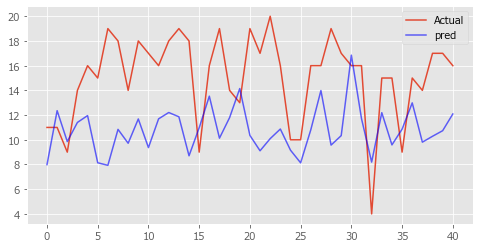

かわいい
11.910528078620635
7.062330623306234


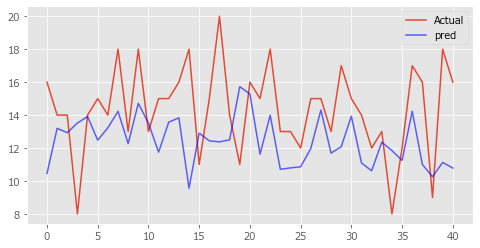

写真の中の位置
3.4990308807869153
2.3429689852454074


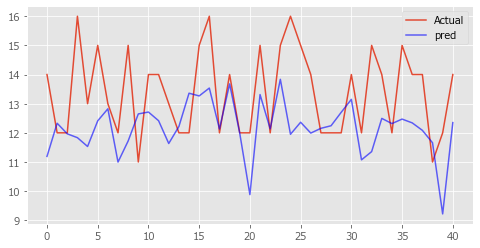

明暗
4.175035675227669
4.049510038996138


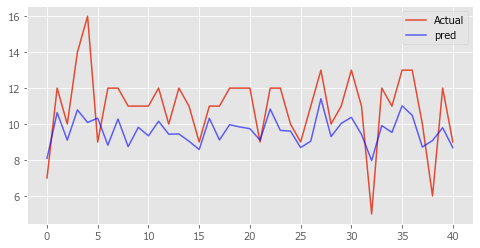

In [66]:
predict_df = pd.DataFrame(index=["MSE_pred","MSE_mean"])

X = np.array(X)

for column in score_df.columns:
    print(column)
    Y = np.array(score_df[column])
    predict_df[column] = column_predict(X,Y)

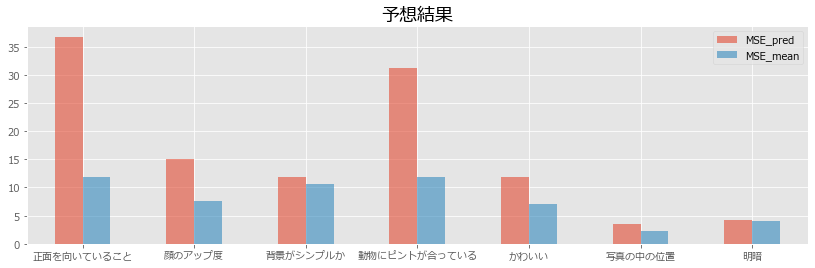

In [67]:
predict_df.T.plot.bar(alpha=0.6, figsize=(14,4))
plt.xticks(rotation=0)
plt.title('予想結果', size=18)
plt.show()